## 0. Preprocess: load data and shuffle it for reliable performance

In [1]:
from load import load_data

x, y = load_data(rsize=128)

print(x.shape)
print(y.shape)

num_classes = 4

(478, 128, 128, 3)
(478,)


In [2]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import LocallyConnected2D, BatchNormalization, Conv2D, MaxPooling2D
from keras.layers import LeakyReLU, Dense, Dropout, Flatten, Softmax
from keras import regularizers
from keras.utils import to_categorical

import matplotlib.pyplot as plt

import numpy as np

Using TensorFlow backend.


## 1. LocallConnectedNet
### the structure of the locally connected network
======locally connected layers======  
----(F, C, H, W)----S-next---params  
L1: (16, 3, 11, 11) 3 40,   9318400  
L2: (16, 16, 9, 9)  1 32,   21250048  
L3: (16, 16, 9, 9)  1 24,   11953152  
======fully connected layers========  
F1: (24*24*16, 300)  
F2: (300, 300)  
F3: (300, 300)  
======output layer==================  
F:  (300, 4)
softmax


In [3]:
# kernel_regularizer=regularizers.l2(0.001)

def LocallyConnectedNet():
    model = Sequential()

   # N, 3 ,128, 128
    model.add(BatchNormalization(axis=1, input_shape=(128, 128, 3)))
    model.add(LeakyReLU(alpha=0.05))
    
    model.add(LocallyConnected2D(16, 11, strides=(3, 3)))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.05))

    # N, 16, 40, 40
    model.add(LocallyConnected2D(16, 9))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.05))

    # N, 16, 32, 32
    model.add(LocallyConnected2D(16, 9))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.05))
    
    # N, 16, 24, 24
    model.add(Flatten())
    
    # N, 16*24*24
    model.add(Dense(300))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.05))
    model.add(Dropout(0.5))

    model.add(Dense(300))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.05))
    model.add(Dropout(0.5))

    model.add(Dense(300))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.05))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes))
    model.add(Softmax())
    
    return model

### sanity check
overfitting on a small subset of training data to verify the sanity of the architecture

In [4]:
# overfitting on small set of data

x_pre, y_pre = x[:30], y[:30]
y_pre = to_categorical(y_pre, num_classes)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
30/30 [==============================] - 118s 4s/step - loss: 2.4451 - acc: 0.0667 
Epoch 2/20
30/30 [==============================] - 29s 983ms/step - loss: 1.6762 - acc: 0.3333
Epoch 3/20
30/30 [==============================] - 32s 1s/step - loss: 1.2360 - acc: 0.3667
Epoch 4/20
30/30 [==============================] - 31s 1s/step - loss: 0.9414 - acc: 0.6000
Epoch 5/20
30/30 [==============================] - 33s 1s/step - loss: 0.7275 - acc: 0.6667
Epoch 6/20
30/30 [==============================] - 31s 1s/step - loss: 0.4809 - acc: 0.9000
Epoch 7/20
30/30 [==============================] - 30s 1s/step - loss: 0.3188 - acc: 0.9333
Epoch 8/20
30/30 [==============================] - 33s 1s/step - loss: 0.2540 - acc: 0.9000
Epoch 9/20
30/30

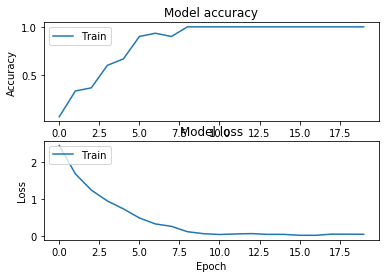

In [5]:
model = LocallyConnectedNet()
optim = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
hist = model.fit(x_pre, y_pre, batch_size=15, epochs=20, shuffle=True)

plt.figure()
plt.subplot(2,1,1)
plt.plot(hist.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(hist.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

### cross validate the loss and accuracy of LocallConnectedNet
Since the training dataset is very small, we use 4-fold cross validation to evaluate loss and accuracy of the model.

In [ ]:
# split for cross validation
delim = [400,]
xs = np.split(x, delim)
ys = np.split(y, delim)

# validation
loss, acc = 0, 0
x_train = xs[0]
x_val = xs[1]
y_train = to_categorical(ys[0], num_classes)
y_val = to_categorical(ys[1], num_classes)

# establish model
model = LocallyConnectedNet()
    
optim = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=16, epochs=20, shuffle=True)
    
plt.figure()
plt.subplot(2,1,1)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Train on 400 samples, validate on 78 samples
Epoch 1/20
400/400 [==============================] - 717s 2s/step - loss: 1.4336 - acc: 0.4325 - val_loss: 2.8109 - val_acc: 0.0385
Epoch 2/20
400/400 [==============================] - 665s 2s/step - loss: 1.1678 - acc: 0.5875 - val_loss: 4.7834 - val_acc: 0.0000e+00
Epoch 3/20
368/400 [==========================>...] - ETA: 54s - loss: 0.7082 - acc: 0.7201 